In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Pre-processors
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Model Performance Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [ ]:
df = pd.read_csv("./Data Source/Prepared/yearly_temp_merged_df_with_pop.csv", index_col=0)
df.head()

,Area Code (FAO),Area,Year,Value,Annual CO₂ emissions growth (%),Population growth (annual %),Annual methane emissions in CO₂ equivalents,Annual nitrous oxide emissions in CO₂ equivalents,GDP (in USD),population
0,2,Afghanistan,1961,-0.121,18.583180,1.925952,9611760.0,2917273.5,NaN,8790140.0
1,2,Afghanistan,1962,-0.171,40.300896,2.014879,9902082.0,2891160.8,NaN,8969047.0
2,2,Afghanistan,1963,0.841,2.634644,2.078997,10253045.0,2941533.2,NaN,9157465.0
3,2,Afghanistan,1964,-0.779,18.651236,2.139651,10526705.0,3004207.0,NaN,9355514.0
4,2,Afghanistan,1965,-0.254,20.078205,2.216007,10853354.0,3075739.0,NaN,9565147.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10609 entries, 0 to 10608
Data columns (total 10 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Area Code (FAO)                                    10609 non-null  int64  
 1   Area                                               10609 non-null  object 
 2   Year                                               10609 non-null  int64  
 3   Value                                              10318 non-null  float64
 4   Annual CO₂ emissions growth (%)                    9841 non-null   float64
 5   Population growth (annual %)                       10266 non-null  float64
 6   Annual methane emissions in CO₂ equivalents        9468 non-null   float64
 7   Annual nitrous oxide emissions in CO₂ equivalents  9648 non-null   float64
 8   GDP (in USD)                                       8482 non-null   float64
 9   population 

In [ ]:
print(f"Number of records in dataframe: {len(df)}")

# removing rows where the column Value contains NAN
print(f"There are {len(df[df['Value'].isna()])} rows with NA in Value column")

df = df[~df['Value'].isna()]
print(f"Number of records in dataframe after removing NAs: {len(df)}")

Number of records in dataframe: 10609
There are 291 rows with NA in Value column
Number of records in dataframe after removing NAs: 10318


In [ ]:
# rename column names
column_names = {
    "Area Code (FAO)":"area_code",
    "Year" : "year",
    "Annual CO₂ emissions growth (%)" : "co2_emissions_rate",
    "Population growth (annual %)" : "pop_growth_rate",
    "Annual methane emissions in CO₂ equivalents" : "methane_emissions",
    "Annual nitrous oxide emissions in CO₂ equivalents" : "nitrous_oxide_emissions",
    "GDP (in USD)" : "gdp_usd"
    }

df.rename(columns=column_names, inplace=True)

# split the dataset into train and test sets
X = df.drop(['Value', 'Area'], axis=1)
y = df.Value

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=143, stratify=X['year'])

In [ ]:
# getting the numeric and categorical feature names
numeric_features = ['area_code', 'co2_emissions_rate', 'pop_growth_rate', 'methane_emissions', 'nitrous_oxide_emissions', 'gdp_usd', 'population']
categorical_features = ['year']

print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

Numeric Features: ['area_code', 'co2_emissions_rate', 'pop_growth_rate', 'methane_emissions', 'nitrous_oxide_emissions', 'gdp_usd', 'population']
Categorical Features: ['year']


In [ ]:
# creating the transformers and pipelines
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('encoder', OrdinalEncoder())
    ]
)

processor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [ ]:
# defining the function to calculate the model performance metrics
def model_performance(model, X_train, y_train, X_test, y_test):
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)

    metrics = pd.DataFrame(
        {
            "R²": [model.score(X_train, y_train), model.score(X_test, y_test)],
            "MSE": [mean_squared_error(y_train, predictions_train), mean_squared_error(y_test, predictions_test)],
            "MAE": [mean_absolute_error(y_train, predictions_train), mean_absolute_error(y_test, predictions_test)],
            "RMSE": [np.sqrt(mean_squared_error(y_train, predictions_train)), np.sqrt(mean_squared_error(y_test, predictions_test))]
        },
        index=["Train", "Test"]
    )
    return metrics

### Ridge Regression Model

In [ ]:
# Ridge Piepline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', processor),
    ('regressor', Ridge())
])

ridge_pipeline.fit(X_train, y_train)
ridge_predicts_test = ridge_pipeline.predict(X_test)

print("Predictions:\n", ridge_predicts_test)
model_performance(ridge_pipeline, X_train, y_train, X_test, y_test)

Predictions:
 [ 1.23340102  0.13123973  0.68580978 ...  0.20092221 -0.29680317
  0.46478343]


,R²,MSE,MAE,RMSE
Train,0.492106,0.213631,0.354141,0.462203
Test,0.493512,0.216279,0.351108,0.465058


Text(0.5, 1.0, "Ridge Regressor's Predictions vs. Actual Values")

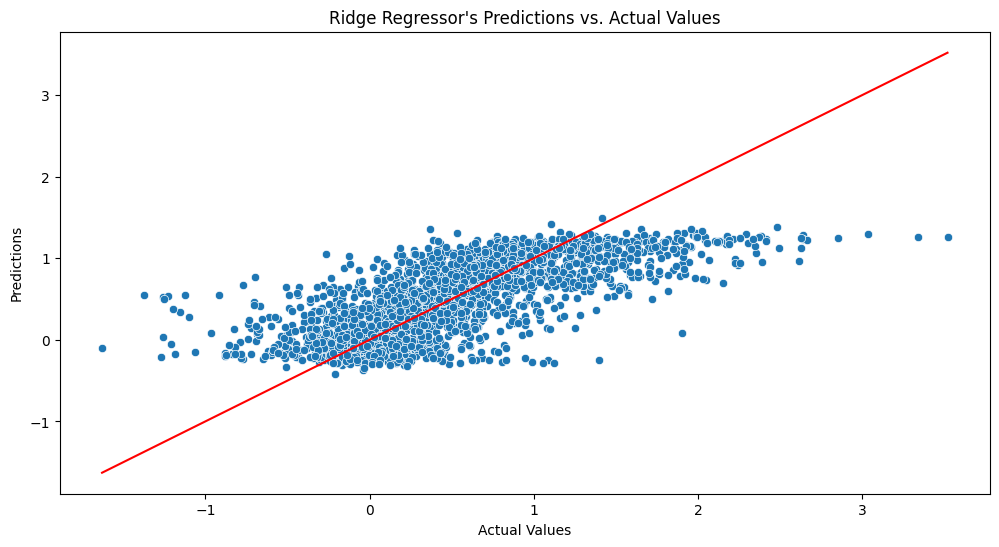

In [ ]:
# Plotting the prediction vs. actual target values
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=ridge_predicts_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'red')

plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title("Ridge Regressor's Predictions vs. Actual Values")

,Feature,Importance
0,area_code,0.036369
1,year,0.000773
2,co2_emissions_rate,-0.017717
3,pop_growth_rate,0.000590
4,methane_emissions,0.003396
5,nitrous_oxide_emissions,0.001508
6,gdp_usd,-0.004034
7,population,0.025725


Text(0.5, 1.0, "Ridge Regression's Feature Importance")

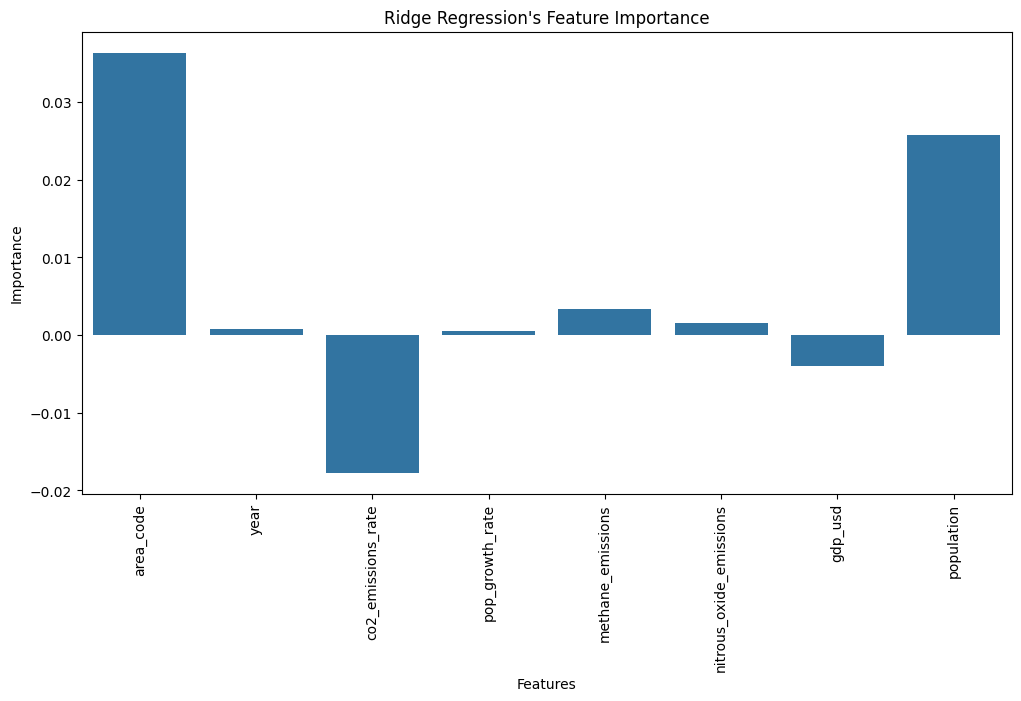

In [ ]:
# Analyzing the importance of features
feature_importance = pd.DataFrame(list(zip(X.columns, ridge_pipeline.named_steps['regressor'].coef_)), columns=['Feature', 'Importance'])
display(feature_importance)

# Plotting the feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Importance', data=feature_importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.title("Ridge Regression's Feature Importance")

### Random Forest Regressor Model

In [ ]:
# Random Forest Regressor Model Piepline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', processor),
    ('regressor', RandomForestRegressor(random_state=123))
])

rf_pipeline.fit(X_train, y_train)
rf_predicts_test = rf_pipeline.predict(X_test)

print("Predictions:\n", rf_predicts_test)
model_performance(rf_pipeline, X_train, y_train, X_test, y_test)

Predictions:
 [2.31092 0.21976 0.99274 ... 0.05257 0.21274 0.17231]


,R²,MSE,MAE,RMSE
Train,0.955379,0.018769,0.100303,0.136998
Test,0.692221,0.131427,0.265966,0.362528


Text(0.5, 1.0, "Random Forest Regressor's Predictions vs. Actual Values")

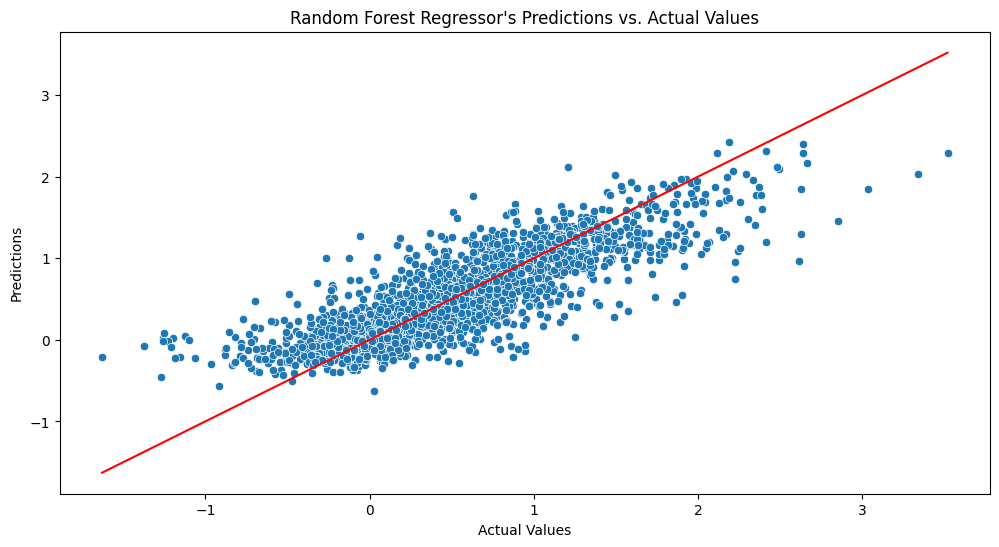

In [ ]:
# Plotting the prediction vs. actual target values
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=rf_predicts_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'red')

plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title("Random Forest Regressor's Predictions vs. Actual Values")

,Feature,Importance
0,area_code,0.048205
1,year,0.057482
2,co2_emissions_rate,0.087666
3,pop_growth_rate,0.046047
4,methane_emissions,0.061598
5,nitrous_oxide_emissions,0.059240
6,gdp_usd,0.056584
7,population,0.583177


Text(0.5, 1.0, "Random Forest Regressor's Feature Importance")

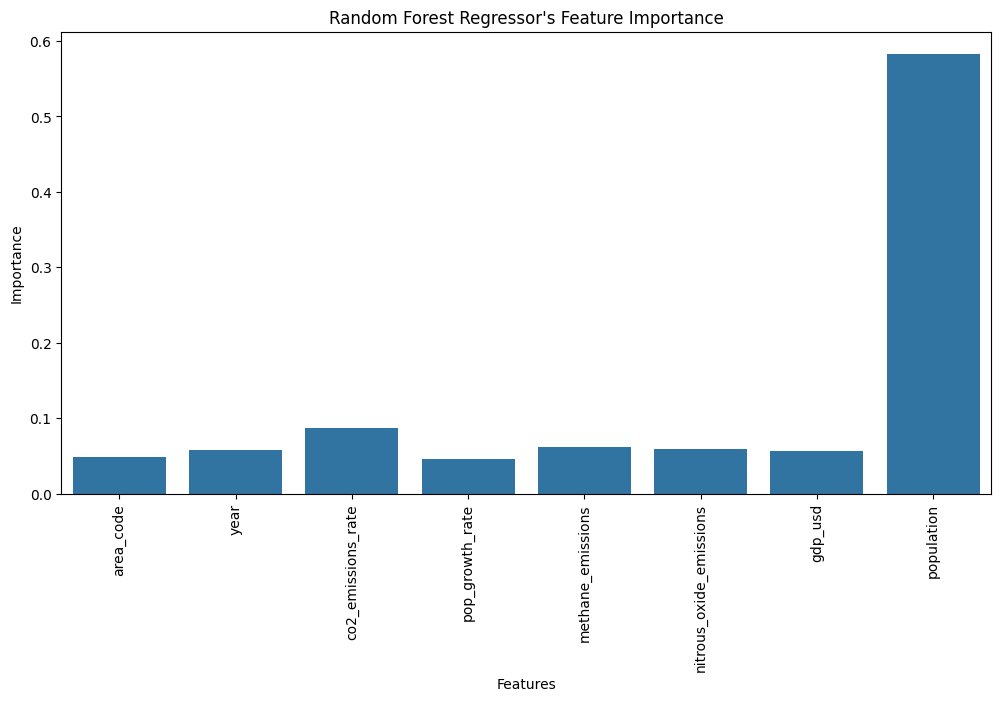

In [ ]:
# Analyzing the importance of features
feature_importance = pd.DataFrame(list(zip(X.columns, rf_pipeline.named_steps['regressor'].feature_importances_)), columns=['Feature', 'Importance'])

display(feature_importance)

# Plotting the feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Importance', data=feature_importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.title("Random Forest Regressor's Feature Importance")